# Exploring U-Net Activations

> This notebook covers the necessary steps to experiment with a simple U-Net architecture, visualizing its activations.

We will approach the following:

- Defining a simple U-Net model for semantic segmentation of parasites;
- Defining a Dataloader for model training, using torch `Dataset` and `DataLoader`;
- Saving U-Net activations for visualization;
- Computing metrics from the predicted segmentation masks.

## Dataset

Let us first define our dataset, we will explore the parasite egg dataset, towards 2D segmentation. The eggs are from Schistossoma Mansoni.

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

In [2]:
# The dataset path - Path to parasite images and labels
# reshaped to 240x240 pixels

#data_path = Path("/home/afalcao/data/parasites/TFTestQuantified/exper")
#orig_path = data_path / Path("orig")
#labels_path = data_path / Path("label")

data_path = Path("/home/john_doe/msc/2_datasets/parasites")
orig_path = data_path / Path("all_images")
labels_path = data_path / Path("all_truelabels")

In [3]:
# Method to plot original and label images 
def plot_image_with_label(image, label):
    image_path = orig_path / Path(image)
    label_path = labels_path / Path(label)
    
    image = Image.open(image_path)
    label = Image.open(label_path)
    
    print(f"[Image] Format: {image.format} | Size: {image.size} | Mode: {image.mode}")
    print(f"[Label] Format: {label.format} | Size: {label.size} | Mode: {label.mode}")
    
    plt.subplot(121)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(122)
    plt.yticks([]),plt.xticks([])
    plt.title("Label")
    plt.imshow(label, cmap="gray")
    

Our dataset contains 96 images. We will further divide it into training and testing images. We will use ~80% to train (76) and ~20% to test (20) the model.

[Image] Format: PNG | Size: (240, 240) | Mode: RGB
[Label] Format: PNG | Size: (240, 240) | Mode: L


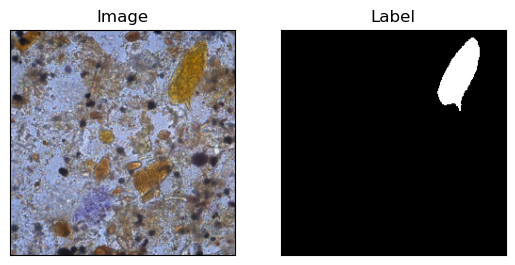

In [4]:
images = os.listdir(orig_path)
images.sort()
labels = images # Label images have the same filename of the originals
n_train = int((0.8 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]

# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

# Image idx to visualize
idx = 0
plot_image_with_label(train_images[idx], train_labels[idx])

## Dataset and Dataloader

Now, we need to define the Dataset and Dataloader classes. They must:

- Enable training and testing with a single image
- Enable training and testing using the data splits

In [5]:
# Necessary libraries
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps

In [6]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        """Transform input images to normalized tensors.
        [0, 255] -> [0, 1]
        """
        self.image_transforms = transforms.ToTensor()
        self.label_transforms = transforms.ToTensor()

    def __len__(self):
        # If image id not provided, we are training with all data
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = self.image_transforms(Image.open(image_path))
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.label_transforms(label)
        
        # Redefine the label image to have two prediction channels: 
        # the Background and Foreground channels.
        background = torch.zeros(1, label.shape[1], label.shape[2])
        foreground = torch.zeros(1, label.shape[1], label.shape[2])
        background[label == 0] = 1
        foreground[label == 1] = 1
        label = torch.cat([background, foreground], axis=0)

        return image, label

In [7]:
# Dataset with all images
seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=images,
    labels=labels,
    image_id=0 # the image index for training and testing 
               # with a single image or use None for 
               # training and testing with the data split 
)

In [8]:
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    viz_array = np.zeros(shape=(img.shape[1], img.shape[2], img.shape[0]))
    viz_array[:, :, 0] = img[0, :, :]
    viz_array[:, :, 1] = img[1, :, :]
    viz_array[:, :, 2] = img[2, :, :]
    
    print("Foreground shape => ", img.shape)
    print("label shape => ", label.shape)
        
    plt.subplot(131)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(viz_array)
    plt.subplot(132)
    plt.yticks([]),plt.xticks([])
    plt.title("Background")
    plt.imshow(label[0], cmap="gray")
    plt.subplot(133)
    plt.yticks([]),plt.xticks([])
    plt.title("Foreground")
    plt.imshow(label[1], cmap="gray")
    

Foreground shape =>  torch.Size([3, 240, 240])
label shape =>  torch.Size([2, 240, 240])


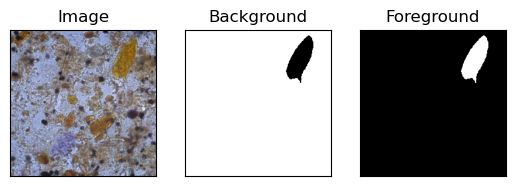

In [9]:
## Visualize image item (Given an ID)
visualize_dataset_item(seg_dataset, 0)

Now, let's define samples of a DataLoader. For training and testing with a single image, use batch size 1. Otherwise, use batch size 8.

In [10]:
# Example of defining a Dataloader (Single Image)

seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
sample_dataloader = DataLoader(seg_dataset, batch_size=1, shuffle=False)
sample_train_images, sample_train_labels = next(iter(sample_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)


Images shape =>  torch.Size([1, 3, 240, 240])
Labels shape =>  torch.Size([1, 2, 240, 240])


In [11]:
# Example of defining a Dataloader (using the data split)
'''
seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
sample_dataloader = DataLoader(seg_dataset, batch_size=8, shuffle=True)
sample_train_images, sample_train_labels = next(iter(sample_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)
'''

'\nseg_dataset = SegDataset(\n    images_path=orig_path,\n    labels_path=labels_path,\n    images=train_images,\n    labels=train_labels,\n    image_id=None\n)\nsample_dataloader = DataLoader(seg_dataset, batch_size=8, shuffle=True)\nsample_train_images, sample_train_labels = next(iter(sample_dataloader))\nprint("Images shape => ", sample_train_images.shape)\nprint("Labels shape => ", sample_train_labels.shape)\n'

## Model

Now, we define our U-Net model. We must enable it to store the activation maps for visual analysis.

In [12]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

In [13]:
# Utilitarians blocks for UNet Decoder

# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [14]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        
        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[1], out_channels=n_kernels[2],
                kernel_size=kernel_sizes[2],
                padding=kernel_sizes[2] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=2, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        x3 = self.block3(x2)
        self.activations["encoder"].append(x3)
        
        # Bottleneck
        bottleneck = self.bottleneck(x3)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.image_transforms(Image.open(image_path))
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to("cuda")
            self.to("cuda")
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

In [15]:
unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[7, 7, 7],
    bottleneck_size=3,
    activations_path=data_path / Path("test")
)

In [16]:
y = unet.forward(sample_train_images)
print(y.shape)

torch.Size([1, 2, 240, 240])


In [17]:
# Uncomment this block to save model architecture to PNG

# Install hiddenlayer package (version without bug on graph tracing)
'''
!python -m pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git
import hiddenlayer as hl
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
graph = hl.build_graph(unet, train_images, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('unet_simple', format='png')
'''

"\n!python -m pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git\nimport hiddenlayer as hl\ntransforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.\ngraph = hl.build_graph(unet, train_images, transforms=transforms)\ngraph.theme = hl.graph.THEMES['blue'].copy()\ngraph.save('unet_simple', format='png')\n"

## Finaly, we define and test our training loop

In [18]:
from torch_snippets import optim, Report
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

In [19]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=False, batch=False),
    "dice_focal": DiceFocalLoss()
}

class Loss(nn.Module):
    def __init__(
            self,
            loss_fn: Union[torch.nn.modules.loss, monai.losses],
            weights: List[float] = [1.0, 1.0]
        ):
        super().__init__()
        self.loss_fn = loss_fn
        self.background_weight = weights[0]
        self.foreground_weight = weights[1]

    def forward(self, y_pred, y_true):
        background_loss = self.loss_fn(y_pred[:,0, ...], y_true[:, 0, ...])
        foreground_loss = self.loss_fn(y_pred[:,1, ...], y_true[:, 1, ...])
        background_loss *= self.background_weight
        foreground_loss *= self.foreground_weight
        loss = background_loss + foreground_loss
        return loss

In [20]:
# Finaly, we define and test our training loop
# Save activations every N epochs
N_SAVE_ACTIVATIONS = 200
def train_loop(epochs, model, dataloader, lr, loss_function, weights):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to("cuda")
    logger = Report(epochs)
    loss = Loss(loss_function, weights)

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to("cuda")
            ground_truth = ground_truth.to("cuda")
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = nn.functional.sigmoid(prediction)
            loss_value = loss(prediction, ground_truth)

            accuracy = (
                (prediction[:,1,...] > prediction[:,0,...]) == ground_truth[:,1,...]
            ).float().mean()
            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

We have defined the following architecture:

![](arch_sample.png)

EPOCH: 1.000  trn_loss: 1.427  trn_accuracy: 0.455  (0.44s - 219.83s remaining)
EPOCH: 2.000  trn_loss: 1.410  trn_accuracy: 0.495  (0.46s - 115.51s remaining)
EPOCH: 3.000  trn_loss: 1.397  trn_accuracy: 0.518  (0.49s - 80.42s remaining)
EPOCH: 4.000  trn_loss: 1.382  trn_accuracy: 0.564  (0.51s - 62.86s remaining)
EPOCH: 5.000  trn_loss: 1.371  trn_accuracy: 0.591  (0.53s - 52.30s remaining)
EPOCH: 6.000  trn_loss: 1.360  trn_accuracy: 0.613  (0.55s - 45.26s remaining)
EPOCH: 7.000  trn_loss: 1.351  trn_accuracy: 0.637  (0.57s - 40.23s remaining)
EPOCH: 8.000  trn_loss: 1.342  trn_accuracy: 0.656  (0.59s - 36.48s remaining)
EPOCH: 9.000  trn_loss: 1.333  trn_accuracy: 0.678  (0.62s - 33.58s remaining)
EPOCH: 10.000  trn_loss: 1.325  trn_accuracy: 0.695  (0.64s - 31.22s remaining)
EPOCH: 11.000  trn_loss: 1.316  trn_accuracy: 0.712  (0.66s - 29.28s remaining)
EPOCH: 12.000  trn_loss: 1.308  trn_accuracy: 0.728  (0.68s - 27.69s remaining)
EPOCH: 13.000  trn_loss: 1.299  trn_accuracy: 0

100%|██████████| 76/76 [00:16<00:00,  4.67it/s]


EPOCH: 201.000  trn_loss: 0.227  trn_accuracy: 0.968  (20.72s - 30.82s remaining)
EPOCH: 202.000  trn_loss: 0.224  trn_accuracy: 0.968  (20.74s - 30.60s remaining)
EPOCH: 203.000  trn_loss: 0.222  trn_accuracy: 0.968  (20.76s - 30.38s remaining)
EPOCH: 204.000  trn_loss: 0.220  trn_accuracy: 0.968  (20.78s - 30.16s remaining)
EPOCH: 205.000  trn_loss: 0.217  trn_accuracy: 0.968  (20.80s - 29.94s remaining)
EPOCH: 206.000  trn_loss: 0.215  trn_accuracy: 0.968  (20.82s - 29.72s remaining)
EPOCH: 207.000  trn_loss: 0.213  trn_accuracy: 0.968  (20.84s - 29.50s remaining)
EPOCH: 208.000  trn_loss: 0.211  trn_accuracy: 0.968  (20.86s - 29.29s remaining)
EPOCH: 209.000  trn_loss: 0.209  trn_accuracy: 0.968  (20.88s - 29.07s remaining)
EPOCH: 210.000  trn_loss: 0.207  trn_accuracy: 0.968  (20.90s - 28.86s remaining)
EPOCH: 211.000  trn_loss: 0.205  trn_accuracy: 0.968  (20.92s - 28.65s remaining)
EPOCH: 212.000  trn_loss: 0.203  trn_accuracy: 0.968  (20.94s - 28.45s remaining)
EPOCH: 213.000  

100%|██████████| 76/76 [00:15<00:00,  4.91it/s]


EPOCH: 401.000  trn_loss: 0.093  trn_accuracy: 0.968  (40.24s - 9.93s remaining)
EPOCH: 402.000  trn_loss: 0.093  trn_accuracy: 0.968  (40.26s - 9.81s remaining)
EPOCH: 403.000  trn_loss: 0.093  trn_accuracy: 0.968  (40.28s - 9.70s remaining)
EPOCH: 404.000  trn_loss: 0.093  trn_accuracy: 0.968  (40.30s - 9.58s remaining)
EPOCH: 405.000  trn_loss: 0.093  trn_accuracy: 0.968  (40.32s - 9.46s remaining)
EPOCH: 406.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.35s - 9.34s remaining)
EPOCH: 407.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.37s - 9.22s remaining)
EPOCH: 408.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.39s - 9.11s remaining)
EPOCH: 409.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.41s - 8.99s remaining)
EPOCH: 410.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.43s - 8.87s remaining)
EPOCH: 411.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.45s - 8.76s remaining)
EPOCH: 412.000  trn_loss: 0.092  trn_accuracy: 0.968  (40.47s - 8.64s remaining)
EPOCH: 413.000  trn_loss: 0.

100%|██████████| 601/601 [00:00<00:00, 26472.07it/s]


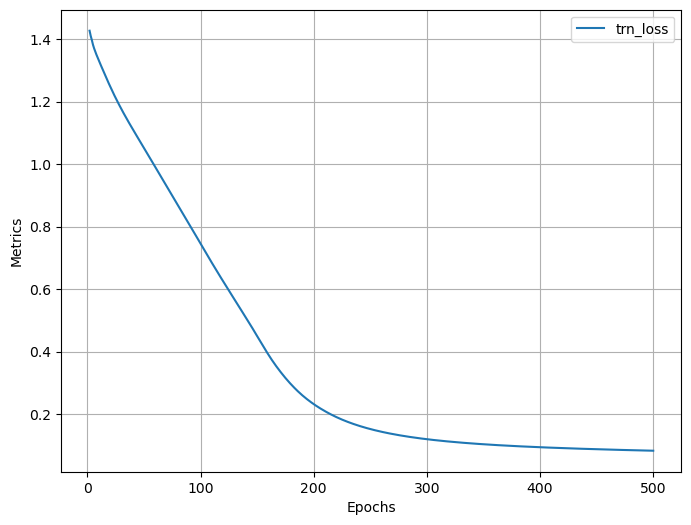

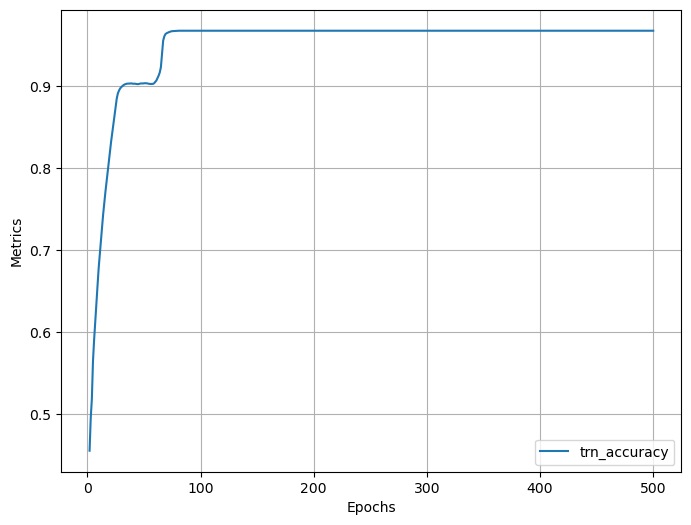

In [21]:
# SET ACTIVATIONS PATH TO EXPORT ENCODER/DECODER ACTIVATIONS AND LEARNING CURVES
kernel_size = 7

unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_dice_focal_fulldata".format(kernel_size))
)

train_loop(
    epochs=500,
    model=unet,
    dataloader=sample_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)

Finally, we define a method to use our trained model and predict a segmentation map. We also compute metrics between the prediction map and the ground-truth.

In [22]:
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

In [23]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=1, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(Image.open(image_path))
        ground_truth = data_loader.dataset.label_transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to("cuda")
        prediction = model(image_data)
        prediction = nn.functional.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy()
        mask[(prediction[0,1,...] > prediction[0,0,...])] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        dice = binary.dc(mask, ground_truth)
        dices.append(dice)
        iou = jaccard_index(torch.Tensor(mask), torch.Tensor(ground_truth))
        ious.append((iou.numpy()))
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")
    
    nan_index = np.argwhere(np.isnan(ious))
    accuracies = np.delete(accuracies, nan_index)
    dices = np.delete(dices, nan_index)
    ious = np.delete(ious, nan_index)
    
    print(f"[INFO - Without NaN] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO - Without NaN] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO - Without NaN] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

In [24]:
predict_and_evaluate(model=unet, data_loader=sample_dataloader)

76it [00:00, 88.20it/s]

[INFO] Avg Accuracy: 0.9879982471466064 +/- 0.011624940671026707
[INFO] Avg Dice: 0.0 +/- 0.0
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9777528643608093 +/- 0.004750782623887062
[INFO - Without NaN] Avg Dice: 0.0 +/- 0.0
[INFO - Without NaN] Avg IoU: 0.0 +/- 0.0


Now, let us run 3 experiments to verify how U-Net tackles training with different ammount of data:

- First, we train our network on only one image and then evaluate it on test set;
- Then, we train our network on all training images and evaluate it on test set;
- Finnaly, we train it on ~10% of our training data (7 images) and evaluate it on test set.

___

# Training with a single image

EPOCH: 1.000  trn_loss: 1.427  trn_accuracy: 0.455  (0.02s - 22.19s remaining)
EPOCH: 2.000  trn_loss: 1.343  trn_accuracy: 0.660  (0.05s - 22.56s remaining)
EPOCH: 3.000  trn_loss: 1.269  trn_accuracy: 0.795  (0.07s - 22.04s remaining)
EPOCH: 4.000  trn_loss: 1.200  trn_accuracy: 0.864  (0.09s - 21.66s remaining)
EPOCH: 5.000  trn_loss: 1.135  trn_accuracy: 0.892  (0.11s - 21.35s remaining)
EPOCH: 6.000  trn_loss: 1.071  trn_accuracy: 0.911  (0.13s - 21.11s remaining)
EPOCH: 7.000  trn_loss: 1.008  trn_accuracy: 0.923  (0.15s - 20.93s remaining)
EPOCH: 8.000  trn_loss: 0.948  trn_accuracy: 0.968  (0.17s - 20.69s remaining)
EPOCH: 9.000  trn_loss: 0.891  trn_accuracy: 0.968  (0.19s - 20.52s remaining)
EPOCH: 10.000  trn_loss: 0.834  trn_accuracy: 0.968  (0.21s - 20.43s remaining)
EPOCH: 11.000  trn_loss: 0.779  trn_accuracy: 0.968  (0.23s - 20.31s remaining)
EPOCH: 12.000  trn_loss: 0.724  trn_accuracy: 0.968  (0.25s - 20.27s remaining)
EPOCH: 13.000  trn_loss: 0.670  trn_accuracy: 0.9

100%|██████████| 76/76 [00:16<00:00,  4.71it/s]


EPOCH: 201.000  trn_loss: 0.050  trn_accuracy: 0.968  (20.26s - 80.54s remaining)
EPOCH: 202.000  trn_loss: 0.050  trn_accuracy: 0.968  (20.29s - 80.14s remaining)
EPOCH: 203.000  trn_loss: 0.050  trn_accuracy: 0.968  (20.31s - 79.74s remaining)
EPOCH: 204.000  trn_loss: 0.050  trn_accuracy: 0.968  (20.33s - 79.34s remaining)
EPOCH: 205.000  trn_loss: 0.050  trn_accuracy: 0.968  (20.36s - 78.95s remaining)
EPOCH: 206.000  trn_loss: 0.050  trn_accuracy: 0.968  (20.38s - 78.56s remaining)
EPOCH: 207.000  trn_loss: 0.049  trn_accuracy: 0.968  (20.41s - 78.18s remaining)
EPOCH: 208.000  trn_loss: 0.049  trn_accuracy: 0.968  (20.43s - 77.80s remaining)
EPOCH: 209.000  trn_loss: 0.049  trn_accuracy: 0.968  (20.45s - 77.41s remaining)
EPOCH: 210.000  trn_loss: 0.049  trn_accuracy: 0.968  (20.47s - 77.02s remaining)
EPOCH: 211.000  trn_loss: 0.049  trn_accuracy: 0.968  (20.50s - 76.65s remaining)
EPOCH: 212.000  trn_loss: 0.049  trn_accuracy: 0.968  (20.52s - 76.28s remaining)
EPOCH: 213.000  

100%|██████████| 76/76 [00:15<00:00,  5.00it/s]


EPOCH: 401.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.83s - 59.50s remaining)
EPOCH: 402.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.85s - 59.28s remaining)
EPOCH: 403.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.87s - 59.07s remaining)
EPOCH: 404.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.89s - 58.85s remaining)
EPOCH: 405.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.91s - 58.64s remaining)
EPOCH: 406.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.93s - 58.42s remaining)
EPOCH: 407.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.95s - 58.21s remaining)
EPOCH: 408.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.97s - 58.00s remaining)
EPOCH: 409.000  trn_loss: 0.038  trn_accuracy: 0.998  (39.99s - 57.79s remaining)
EPOCH: 410.000  trn_loss: 0.038  trn_accuracy: 0.998  (40.02s - 57.58s remaining)
EPOCH: 411.000  trn_loss: 0.038  trn_accuracy: 0.998  (40.04s - 57.38s remaining)
EPOCH: 412.000  trn_loss: 0.038  trn_accuracy: 0.998  (40.06s - 57.18s remaining)
EPOCH: 413.000  

100%|██████████| 76/76 [00:17<00:00,  4.46it/s]


EPOCH: 601.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.10s - 40.57s remaining)
EPOCH: 602.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.12s - 40.41s remaining)
EPOCH: 603.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.15s - 40.26s remaining)
EPOCH: 604.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.17s - 40.10s remaining)
EPOCH: 605.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.19s - 39.95s remaining)
EPOCH: 606.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.21s - 39.80s remaining)
EPOCH: 607.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.23s - 39.65s remaining)
EPOCH: 608.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.25s - 39.49s remaining)
EPOCH: 609.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.28s - 39.34s remaining)
EPOCH: 610.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.30s - 39.19s remaining)
EPOCH: 611.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.32s - 39.04s remaining)
EPOCH: 612.000  trn_loss: 0.028  trn_accuracy: 0.999  (61.34s - 38.89s remaining)
EPOCH: 613.000  

100%|██████████| 76/76 [00:16<00:00,  4.68it/s]


EPOCH: 801.000  trn_loss: 0.021  trn_accuracy: 0.999  (81.61s - 20.28s remaining)
EPOCH: 802.000  trn_loss: 0.021  trn_accuracy: 0.999  (81.64s - 20.15s remaining)
EPOCH: 803.000  trn_loss: 0.021  trn_accuracy: 0.999  (81.66s - 20.03s remaining)
EPOCH: 804.000  trn_loss: 0.021  trn_accuracy: 0.999  (81.68s - 19.91s remaining)
EPOCH: 805.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.70s - 19.79s remaining)
EPOCH: 806.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.72s - 19.67s remaining)
EPOCH: 807.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.75s - 19.55s remaining)
EPOCH: 808.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.77s - 19.43s remaining)
EPOCH: 809.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.79s - 19.31s remaining)
EPOCH: 810.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.82s - 19.19s remaining)
EPOCH: 811.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.84s - 19.07s remaining)
EPOCH: 812.000  trn_loss: 0.020  trn_accuracy: 0.999  (81.87s - 18.95s remaining)
EPOCH: 813.000  

100%|██████████| 1101/1101 [00:00<00:00, 13707.08it/s]


[INFO] Training Metrics


76it [00:00, 86.49it/s]


[INFO] Avg Accuracy: 0.9914732575416565 +/- 0.008824252523481846
[INFO] Avg Dice: 0.3065231052447947 +/- 0.346591370406837
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9879993200302124 +/- 0.008240269497036934
[INFO - Without NaN] Avg Dice: 0.43140288886304434 +/- 0.33939965960468554
[INFO - Without NaN] Avg IoU: 0.33714547753334045 +/- 0.291120707988739
[INFO] Test Metrics


20it [00:00, 73.08it/s]


[INFO] Avg Accuracy: 0.9934192895889282 +/- 0.007151443976908922
[INFO] Avg Dice: 0.33875125545571844 +/- 0.3561037379396773
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9905989766120911 +/- 0.006822594441473484
[INFO - Without NaN] Avg Dice: 0.48393036493674063 +/- 0.33301708787553425
[INFO - Without NaN] Avg IoU: 0.38141757249832153 +/- 0.28763213753700256


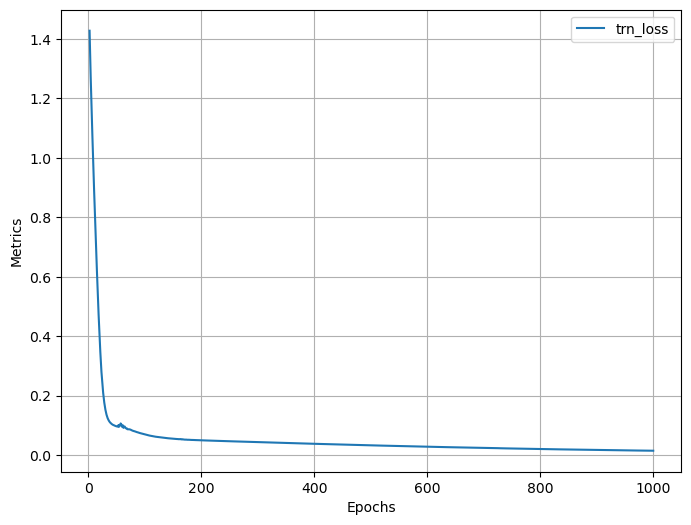

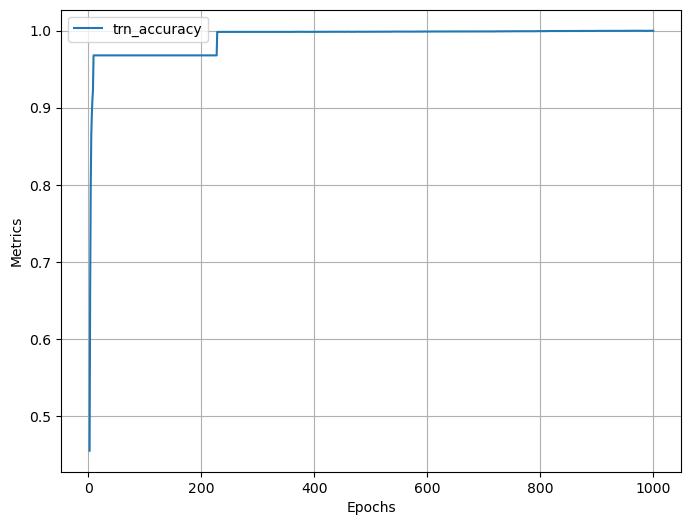

In [25]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_one_image".format(kernel_size))
)


train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-2,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

# Training with the data split

EPOCH: 1.000  trn_loss: 1.404  trn_accuracy: 0.501  (0.89s - 444.20s remaining)
EPOCH: 2.000  trn_loss: 1.386  trn_accuracy: 0.546  (1.76s - 437.60s remaining)
EPOCH: 3.000  trn_loss: 1.372  trn_accuracy: 0.586  (2.62s - 434.27s remaining)
EPOCH: 4.000  trn_loss: 1.358  trn_accuracy: 0.623  (3.50s - 434.11s remaining)
EPOCH: 5.000  trn_loss: 1.345  trn_accuracy: 0.657  (4.44s - 439.70s remaining)
EPOCH: 6.000  trn_loss: 1.332  trn_accuracy: 0.689  (5.34s - 439.93s remaining)
EPOCH: 7.000  trn_loss: 1.325  trn_accuracy: 0.709  (6.21s - 437.57s remaining)
EPOCH: 8.000  trn_loss: 1.313  trn_accuracy: 0.740  (7.08s - 435.57s remaining)
EPOCH: 9.000  trn_loss: 1.303  trn_accuracy: 0.760  (7.96s - 434.00s remaining)
EPOCH: 10.000  trn_loss: 1.294  trn_accuracy: 0.779  (8.82s - 432.33s remaining)
EPOCH: 11.000  trn_loss: 1.284  trn_accuracy: 0.801  (9.70s - 431.33s remaining)
EPOCH: 12.000  trn_loss: 1.277  trn_accuracy: 0.810  (10.60s - 431.04s remaining)
EPOCH: 13.000  trn_loss: 1.268  trn_

100%|██████████| 76/76 [00:18<00:00,  4.00it/s]


EPOCH: 201.000  trn_loss: 0.189  trn_accuracy: 0.988  (206.14s - 306.64s remaining)
EPOCH: 202.000  trn_loss: 0.192  trn_accuracy: 0.986  (207.11s - 305.54s remaining)
EPOCH: 203.000  trn_loss: 0.185  trn_accuracy: 0.988  (208.04s - 304.38s remaining)
EPOCH: 204.000  trn_loss: 0.182  trn_accuracy: 0.989  (208.97s - 303.21s remaining)
EPOCH: 205.000  trn_loss: 0.178  trn_accuracy: 0.990  (209.86s - 301.99s remaining)
EPOCH: 206.000  trn_loss: 0.171  trn_accuracy: 0.993  (210.76s - 300.80s remaining)
EPOCH: 207.000  trn_loss: 0.166  trn_accuracy: 0.995  (211.66s - 299.60s remaining)
EPOCH: 208.000  trn_loss: 0.172  trn_accuracy: 0.991  (212.57s - 298.41s remaining)
EPOCH: 209.000  trn_loss: 0.194  trn_accuracy: 0.978  (213.51s - 297.29s remaining)
EPOCH: 210.000  trn_loss: 0.151  trn_accuracy: 1.000  (214.46s - 296.15s remaining)
EPOCH: 211.000  trn_loss: 0.183  trn_accuracy: 0.982  (215.38s - 295.00s remaining)
EPOCH: 212.000  trn_loss: 0.167  trn_accuracy: 0.990  (216.30s - 293.85s rem

100%|██████████| 76/76 [00:19<00:00,  3.96it/s]


EPOCH: 401.000  trn_loss: 0.061  trn_accuracy: 0.982  (421.18s - 103.98s remaining)
EPOCH: 402.000  trn_loss: 0.057  trn_accuracy: 0.984  (422.18s - 102.92s remaining)
EPOCH: 403.000  trn_loss: 0.072  trn_accuracy: 0.977  (423.25s - 101.87s remaining)
EPOCH: 404.000  trn_loss: 0.061  trn_accuracy: 0.982  (424.17s - 100.79s remaining)
EPOCH: 405.000  trn_loss: 0.048  trn_accuracy: 0.987  (425.17s - 99.73s remaining)
EPOCH: 406.000  trn_loss: 0.035  trn_accuracy: 0.993  (426.23s - 98.68s remaining)
EPOCH: 407.000  trn_loss: 0.031  trn_accuracy: 0.995  (427.26s - 97.63s remaining)
EPOCH: 408.000  trn_loss: 0.045  trn_accuracy: 0.988  (428.25s - 96.57s remaining)
EPOCH: 409.000  trn_loss: 0.057  trn_accuracy: 0.983  (429.24s - 95.50s remaining)
EPOCH: 410.000  trn_loss: 0.048  trn_accuracy: 0.987  (430.23s - 94.44s remaining)
EPOCH: 411.000  trn_loss: 0.056  trn_accuracy: 0.983  (431.21s - 93.38s remaining)
EPOCH: 412.000  trn_loss: 0.032  trn_accuracy: 0.994  (432.20s - 92.31s remaining)


100%|██████████| 601/601 [00:00<00:00, 21657.46it/s]


[INFO] Training Metrics


76it [00:00, 79.02it/s]


[INFO] Avg Accuracy: 0.9879982471466064 +/- 0.011624940671026707
[INFO] Avg Dice: 0.0 +/- 0.0
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9777528643608093 +/- 0.004750782623887062
[INFO - Without NaN] Avg Dice: 0.0 +/- 0.0
[INFO - Without NaN] Avg IoU: 0.0 +/- 0.0
[INFO] Test Metrics


20it [00:01, 11.83it/s]

[INFO] Avg Accuracy: 0.9879522323608398 +/- 0.012367559596896172
[INFO] Avg Dice: 0.0 +/- 0.0
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9780949950218201 +/- 0.007885419763624668
[INFO - Without NaN] Avg Dice: 0.0 +/- 0.0
[INFO - Without NaN] Avg IoU: 0.0 +/- 0.0


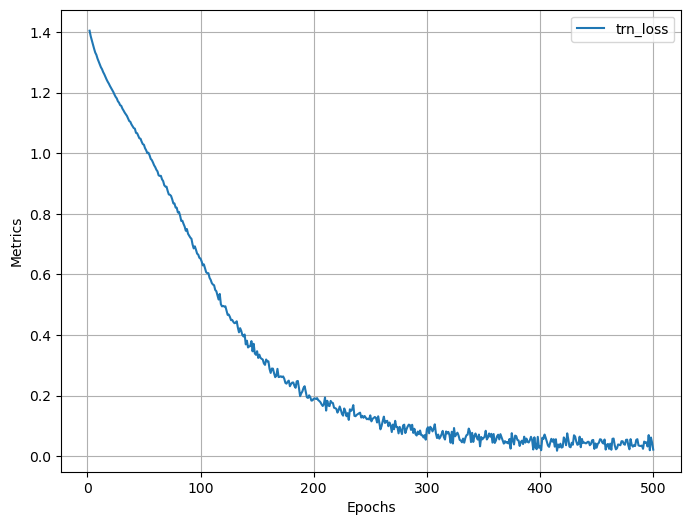

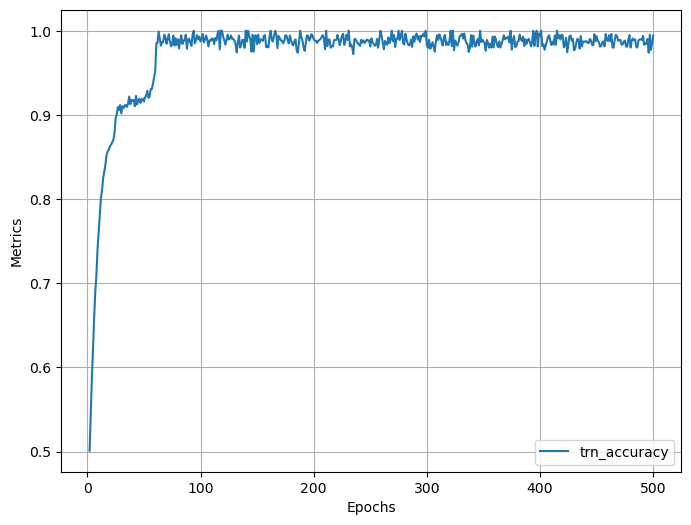

In [26]:
# Training with all training data
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_full_data".format(kernel_size))
)


train_loop(
    epochs=500,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-4,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

# Training with 10% of the training data

EPOCH: 1.000  trn_loss: 1.410  trn_accuracy: 0.488  (0.27s - 270.87s remaining)
EPOCH: 2.000  trn_loss: 1.382  trn_accuracy: 0.554  (0.49s - 246.56s remaining)
EPOCH: 3.000  trn_loss: 1.362  trn_accuracy: 0.609  (0.64s - 213.12s remaining)
EPOCH: 4.000  trn_loss: 1.347  trn_accuracy: 0.647  (0.82s - 204.67s remaining)
EPOCH: 5.000  trn_loss: 1.330  trn_accuracy: 0.684  (1.10s - 218.28s remaining)
EPOCH: 6.000  trn_loss: 1.311  trn_accuracy: 0.724  (1.30s - 216.04s remaining)
EPOCH: 7.000  trn_loss: 1.297  trn_accuracy: 0.754  (1.46s - 207.43s remaining)
EPOCH: 8.000  trn_loss: 1.280  trn_accuracy: 0.780  (1.68s - 208.80s remaining)
EPOCH: 9.000  trn_loss: 1.266  trn_accuracy: 0.805  (1.95s - 214.98s remaining)
EPOCH: 10.000  trn_loss: 1.248  trn_accuracy: 0.833  (2.21s - 219.05s remaining)
EPOCH: 11.000  trn_loss: 1.234  trn_accuracy: 0.857  (2.36s - 211.75s remaining)
EPOCH: 12.000  trn_loss: 1.216  trn_accuracy: 0.879  (2.67s - 220.07s remaining)
EPOCH: 13.000  trn_loss: 1.201  trn_a

100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


EPOCH: 201.000  trn_loss: 0.087  trn_accuracy: 0.971  (45.44s - 180.61s remaining)
EPOCH: 202.000  trn_loss: 0.083  trn_accuracy: 0.973  (45.71s - 180.58s remaining)
EPOCH: 203.000  trn_loss: 0.084  trn_accuracy: 0.973  (45.92s - 180.30s remaining)
EPOCH: 204.000  trn_loss: 0.084  trn_accuracy: 0.973  (46.06s - 179.72s remaining)
EPOCH: 205.000  trn_loss: 0.075  trn_accuracy: 0.976  (46.19s - 179.13s remaining)
EPOCH: 206.000  trn_loss: 0.081  trn_accuracy: 0.974  (46.46s - 179.09s remaining)
EPOCH: 207.000  trn_loss: 0.075  trn_accuracy: 0.976  (46.70s - 178.91s remaining)
EPOCH: 208.000  trn_loss: 0.081  trn_accuracy: 0.973  (46.86s - 178.44s remaining)
EPOCH: 209.000  trn_loss: 0.084  trn_accuracy: 0.972  (46.99s - 177.83s remaining)
EPOCH: 210.000  trn_loss: 0.084  trn_accuracy: 0.972  (47.23s - 177.69s remaining)
EPOCH: 211.000  trn_loss: 0.075  trn_accuracy: 0.976  (47.50s - 177.60s remaining)
EPOCH: 212.000  trn_loss: 0.088  trn_accuracy: 0.970  (47.73s - 177.41s remaining)
EPOC

100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


EPOCH: 401.000  trn_loss: 0.051  trn_accuracy: 0.976  (87.34s - 130.47s remaining)
EPOCH: 402.000  trn_loss: 0.062  trn_accuracy: 0.970  (87.48s - 130.13s remaining)
EPOCH: 403.000  trn_loss: 0.054  trn_accuracy: 0.974  (87.61s - 129.78s remaining)
EPOCH: 404.000  trn_loss: 0.059  trn_accuracy: 0.972  (87.73s - 129.43s remaining)
EPOCH: 405.000  trn_loss: 0.060  trn_accuracy: 0.971  (87.89s - 129.13s remaining)
EPOCH: 406.000  trn_loss: 0.060  trn_accuracy: 0.971  (88.16s - 128.98s remaining)
EPOCH: 407.000  trn_loss: 0.054  trn_accuracy: 0.975  (88.43s - 128.84s remaining)
EPOCH: 408.000  trn_loss: 0.060  trn_accuracy: 0.971  (88.58s - 128.53s remaining)
EPOCH: 409.000  trn_loss: 0.054  trn_accuracy: 0.974  (88.72s - 128.20s remaining)
EPOCH: 410.000  trn_loss: 0.053  trn_accuracy: 0.975  (88.96s - 128.02s remaining)
EPOCH: 411.000  trn_loss: 0.058  trn_accuracy: 0.972  (89.23s - 127.87s remaining)
EPOCH: 412.000  trn_loss: 0.060  trn_accuracy: 0.971  (89.39s - 127.57s remaining)
EPOC

100%|██████████| 7/7 [00:02<00:00,  2.75it/s]


EPOCH: 601.000  trn_loss: 0.045  trn_accuracy: 0.974  (132.39s - 87.89s remaining)
EPOCH: 602.000  trn_loss: 0.043  trn_accuracy: 0.975  (132.66s - 87.71s remaining)
EPOCH: 603.000  trn_loss: 0.048  trn_accuracy: 0.971  (132.86s - 87.47s remaining)
EPOCH: 604.000  trn_loss: 0.040  trn_accuracy: 0.976  (133.04s - 87.23s remaining)
EPOCH: 605.000  trn_loss: 0.045  trn_accuracy: 0.974  (133.36s - 87.07s remaining)
EPOCH: 606.000  trn_loss: 0.048  trn_accuracy: 0.971  (133.54s - 86.83s remaining)
EPOCH: 607.000  trn_loss: 0.045  trn_accuracy: 0.973  (133.70s - 86.57s remaining)
EPOCH: 608.000  trn_loss: 0.046  trn_accuracy: 0.973  (133.96s - 86.37s remaining)
EPOCH: 609.000  trn_loss: 0.044  trn_accuracy: 0.974  (134.20s - 86.16s remaining)
EPOCH: 610.000  trn_loss: 0.044  trn_accuracy: 0.974  (134.34s - 85.89s remaining)
EPOCH: 611.000  trn_loss: 0.050  trn_accuracy: 0.970  (134.58s - 85.68s remaining)
EPOCH: 612.000  trn_loss: 0.050  trn_accuracy: 0.970  (134.86s - 85.50s remaining)
EPOC

100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


EPOCH: 801.000  trn_loss: 0.038  trn_accuracy: 0.999  (177.04s - 43.98s remaining)
EPOCH: 802.000  trn_loss: 0.041  trn_accuracy: 0.999  (177.22s - 43.75s remaining)
EPOCH: 803.000  trn_loss: 0.040  trn_accuracy: 0.999  (177.36s - 43.51s remaining)
EPOCH: 804.000  trn_loss: 0.037  trn_accuracy: 0.999  (177.57s - 43.29s remaining)
EPOCH: 805.000  trn_loss: 0.040  trn_accuracy: 0.998  (177.89s - 43.09s remaining)
EPOCH: 806.000  trn_loss: 0.043  trn_accuracy: 0.998  (178.07s - 42.86s remaining)
EPOCH: 807.000  trn_loss: 0.038  trn_accuracy: 0.999  (178.23s - 42.63s remaining)
EPOCH: 808.000  trn_loss: 0.037  trn_accuracy: 0.999  (178.53s - 42.42s remaining)
EPOCH: 809.000  trn_loss: 0.044  trn_accuracy: 0.998  (178.81s - 42.22s remaining)
EPOCH: 810.000  trn_loss: 0.044  trn_accuracy: 0.999  (178.96s - 41.98s remaining)
EPOCH: 811.000  trn_loss: 0.043  trn_accuracy: 0.998  (179.10s - 41.74s remaining)
EPOCH: 812.000  trn_loss: 0.043  trn_accuracy: 0.998  (179.23s - 41.50s remaining)
EPOC

100%|██████████| 1101/1101 [00:00<00:00, 7264.56it/s]


[INFO] Training Metrics


7it [00:00, 16.98it/s]


[INFO] Avg Accuracy: 0.9986136555671692 +/- 0.00018936482956632972
[INFO] Avg Dice: 0.9736513645198464 +/- 0.0028291514255063756
[INFO] Avg IoU: 0.9486704468727112 +/- 0.005387204233556986
[INFO - Without NaN] Avg Accuracy: 0.9986136555671692 +/- 0.00018936482956632972
[INFO - Without NaN] Avg Dice: 0.9736513645198464 +/- 0.0028291514255063756
[INFO - Without NaN] Avg IoU: 0.9486704468727112 +/- 0.005387204233556986
[INFO] Test Metrics


20it [00:00, 35.22it/s]


[INFO] Avg Accuracy: 0.9921207427978516 +/- 0.007317572366446257
[INFO] Avg Dice: 0.40523358119215735 +/- 0.40838168043731
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9901508092880249 +/- 0.006894370540976524
[INFO - Without NaN] Avg Dice: 0.5065419764901967 +/- 0.3964246982173064
[INFO - Without NaN] Avg IoU: 0.4294756054878235 +/- 0.34138354659080505


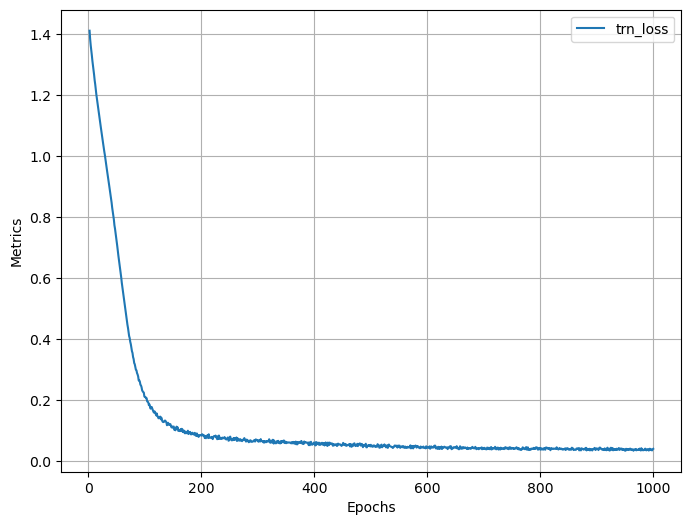

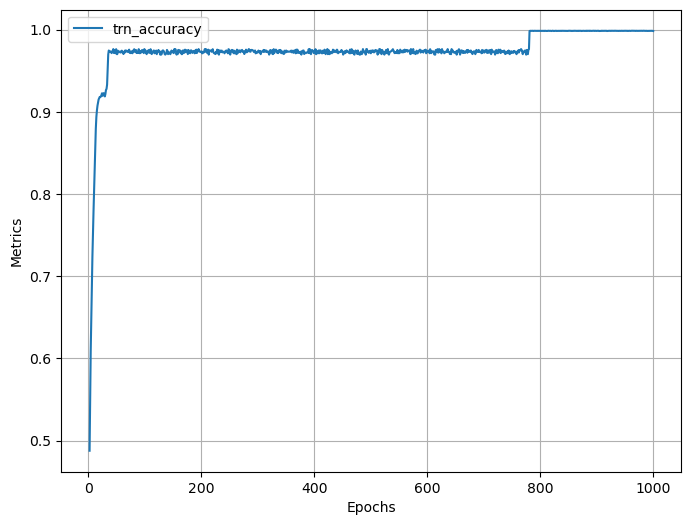

In [34]:
# Training with all training data
n_reduced_data = int(0.10 * len(train_images))
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images[:n_reduced_data],
    labels=train_labels[:n_reduced_data],
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[8, 16, 32],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=data_path / Path("exper/ksize_{}_reduced_data".format(kernel_size))
)


train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1] # Classes weights (Background and Foreground)
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

# Extra - Activities

- Explore different losses, and classes' weights to improve performance metrics (DICE and IoU)
- Explore different size of kernels and visualize model's activations and improvements on performance metrics
- Explore different number of kernels and visualize model's activation and improvements on performance metrics
- Could you apply post-processing on predicted masks to increase performance metrics (e.g., morphological operations)?